# Problem Set 2
## Learning from data [TIF285], Chalmers, Fall 2019

Last revised: 18-Sep-2019 by Christian Forssén [christian.forssen@chalmers.se]

## Instructions

- See deadline on the course web page
- This problem set is performed individually (but collaboration is encouraged) and contains a number of basic and extra problems; you can choose which and how many to work on.
- See examination rules on the course web page.
- Hand-in is performed through the following **two** actions:
  - Upload of your solution in the form of a jupyter notebook, or python code, via Canvas.
  - Answer the corresponding questions on OpenTA.
  
  Note that the hand-in is not complete, and will not be graded, if any of those actions is not performed.

Fill your personal details
- Name: **Jacobsson, Simon**
- Personnummer: **970417-0456**
  <br/>
  (civic registration number)

In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm
from scipy.stats import uniform
import matplotlib.pyplot as plt
import corner
import seaborn as sns
sns.set('talk')
from scipy import stats

np.random.seed(42)

## Problem 1: Coin tossing
### (2 basic points)

Read the data with simulated coin tosses from the file `cointosses.dat`.
Each row corresponds to a single toss: 0=tails; 1=heads

Extract the mean and 95% DOB intervals from the first 8 tosses, the first 64 tosses, the first 512 tosses and all 4096 tosses in the data assuming a uniform prior for the probability $p_H$ of obtaining heads in a single toss.

*Hint*: Sample code for computing the DOB interval is available in the demonstration notebook `demo-BayesianBasics.ipynb`.

for # of tosses = 8,
mean = 0.25
95 % DOB intervall = [0.07 0.6 ]

for # of tosses = 64,
mean = 0.52
95 % DOB intervall = [0.4  0.63]

for # of tosses = 512,
mean = 0.52
95 % DOB intervall = [0.48 0.56]

for # of tosses = 4096,
mean = 0.53
95 % DOB intervall = [0.51 0.54]



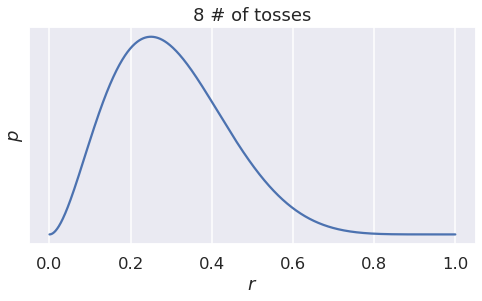

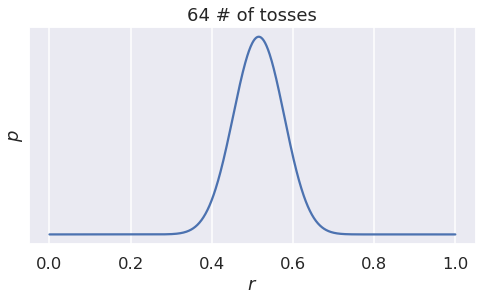

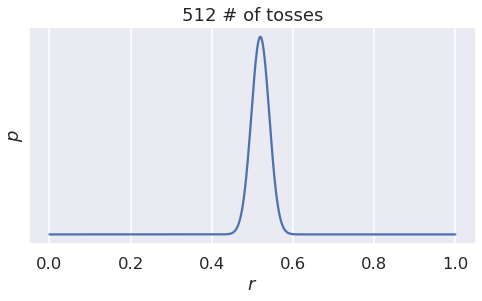

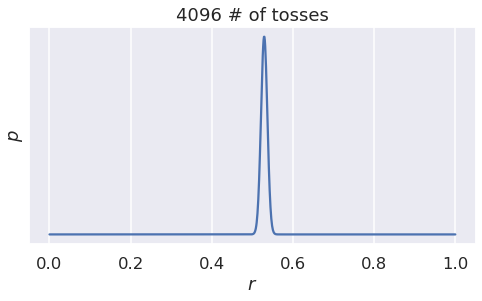

In [2]:
datafile = 'cointosses.dat'
X = np.loadtxt(datafile, unpack=True)

#Our model is p(H) = r.
#Bayes thm ==> p(r|D) = p(D|r) p(r) = {uniform prior} = p(D|r).
#Assume independence ==> p(D|r) = prod_j(p(D_j|r)) where each D_j is a data point (heads or tails).
#p(D_j|r) = r if D_j=1 & 1-r if D_j=0
#==> p(D|r) = r**(nbr_heads) * (1 - r)**(nbr_tails).
#if we introduce the equivalence relation "data set 1 ~ data set 2 if there exists a permutation
#sigma s.th sigma(data set 1) = data set 2", we get 
#p(D|r) = (nbr_tosses choose nbr_heads) * r**(nbr_heads) * (1 - r)**(nbr_tails)
#which is a binomial distribution.

### define likelihood as a distribution on the probability of heads ###
def likelihood(data):
    """
    data is a list of 0s & 1s.
    Returns a scipy.stats distribution
    """
    nbr_heads = (data == 1).sum()
    nbr_tails = (data == 0).sum()
    return stats.beta(nbr_heads+1, nbr_tails+1)

for nbr_tosses in [8, 64, 512, 4096]:
    r_span = np.linspace(0,1, 1000)
    D = X[0:nbr_tosses]
    dist = likelihood(D)

    print(f"for # of tosses = {nbr_tosses},")
    print(f"mean = {D.mean():.2f}")
    print(f"95 % DOB intervall = {np.round(dist.interval(0.95), 2)}\n")

    ### plot likelihood ###
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(r_span, dist.pdf(r_span))
    ax.set_xlabel(r'$r$')
    ax.set_ylabel(r'$p$')
    ax.set_yticks([]);
    ax.set_title(f"{nbr_tosses} # of tosses")


## Problem 2: Straight line fitting
### (2 basic points)

Read the data from the file `straightline.dat`.

We're fitting a straight line to this data. Our model has two parameters $\theta=[m,b]$

$$
y_M(x) = mx + b
$$

And our statistical model assumes that errors are normally distributed

$$
y_i = y_M(x_i;\theta) + \mathcal{N}(0, \sigma),
$$

with fixed $\sigma = 50$

Assume two different priors: a (log) flat prior and a (log) symmetric / scale-invariant prior.

In [3]:
def log_flat_prior(theta):
    if np.all(np.abs(theta) < 1000):
        return 0 # log(1)
    else:
        return -np.inf  # log(0)
    
def log_symmetric_prior(theta):
    if np.abs(theta[0]) < 1000:
        return -1.5 * np.log(1 + theta[1] ** 2)
    else:
        return -np.inf  # log(0)

* Where is the mode of the posterior with these two different priors?
* Plot the joint pdf for the slope and the intercept for the two different prior choices.
* Are the two parameters correlated or anticorrelated?

Lighter regions correspond to higher probability. The mode is indicated by a blue x.


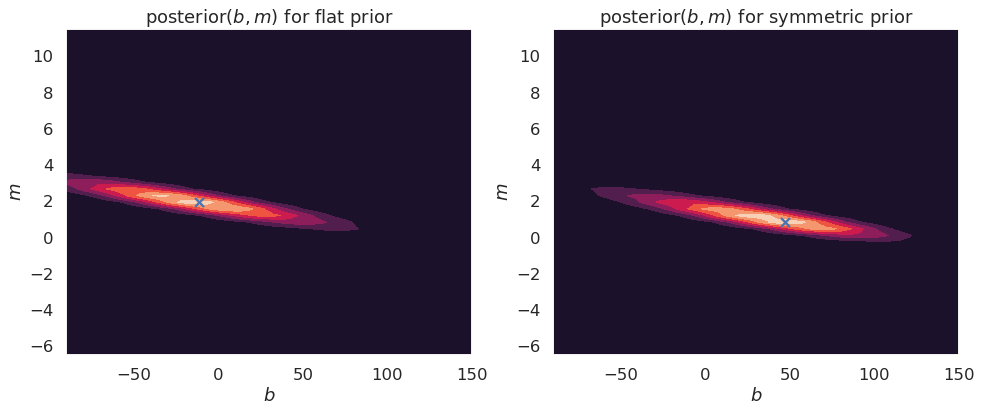

m & b are clearly anticorrelated.
mode from flat:  -11.632653061224488 1.9489795918367356
mode from symmetric:  47.14285714285714 0.8469387755102042


In [19]:
datafile = 'straightline.dat'
x, y = np.loadtxt(datafile, unpack=True)
sigmas = np.array([50 for _ in x])

def log_likelihood(theta, sigmas, x_data, y_data):
    """
    Returns the log of the probability density of x_data & y_data being observed from
    a linear model y = theta[0] * x**0 + theta[1] * x**1 + ... + error where error is
    a random variable with a normal distribution centered at 0 with variance sigma**2
    """
    assert len(sigmas) == len(x_data) and len(x_data) == len(y_data)

    X_d = np.array([x_data**i for i in range(0,len(theta))]).T #design matrix    
    y_pred = X_d.dot(theta)
    sum = (np.log(2 * np.pi * sigmas**2) + (y_data - y_pred)**2 / sigmas**2).sum()
    return -(1/2) * sum

def log_flat_posterior(theta, x_data, y_data):
    return log_flat_prior(theta) + log_likelihood(theta, sigmas, x_data, y_data)

def log_symmetric_posterior(theta, x_data, y_data):
    return log_symmetric_prior(theta) + log_likelihood(theta, sigmas, x_data, y_data)

### initiate some vectors/grids ###
theta0_vec = np.linspace(-120,120) + 30 # b
theta1_vec = np.linspace(-9,9) + 2.5 # m
theta0_grid, theta1_grid = np.meshgrid(theta0_vec, theta1_vec)
log_flat_posterior_grid = np.zeros_like(theta0_grid) #initiate
log_symmetric_posterior_grid = np.zeros_like(theta0_grid) #initiate

### calculate posterior pdfs ###
for i, theta0 in enumerate(theta0_vec):
    for j, theta1 in enumerate(theta1_vec):
        log_flat_posterior_grid[j,i] = log_flat_posterior([theta0, theta1], x, y)
for i, theta0 in enumerate(theta0_vec):
    for j, theta1 in enumerate(theta1_vec):
        log_symmetric_posterior_grid[j,i] = log_symmetric_posterior([theta0, theta1], x, y)

### find mode of posterior ###
max_index_flat = np.unravel_index(np.argmax(log_flat_posterior_grid, axis=None), log_flat_posterior_grid.shape)
max_index_symmetric = np.unravel_index(np.argmax(log_symmetric_posterior_grid, axis=None), log_symmetric_posterior_grid.shape)

### plot pdf:s ###
print('Lighter regions correspond to higher probability. The mode is indicated by a blue x.')
fig, ax = plt.subplots(figsize=(16,6), ncols=2)
ax[0].contourf(theta0_grid, theta1_grid, np.exp(log_flat_posterior_grid)) #plot heat map of pdf
ax[0].scatter(theta0_grid[max_index_flat], theta1_grid[max_index_flat], marker='x', color='b') #indicate where mode occurs
ax[0].set_xlabel(r'$b$')
ax[0].set_ylabel(r'$m$')
ax[0].set_title(r'posterior($b, m$) for flat prior')

ax[1].contourf(theta0_grid, theta1_grid, np.exp(log_symmetric_posterior_grid)) #plot heat map of pdf
ax[1].scatter(theta0_grid[max_index_symmetric], theta1_grid[max_index_symmetric], marker='x', color='b') #indicate where mode occurs
ax[1].set_xlabel(r'$b$')
ax[1].set_ylabel(r'$m$')
ax[1].set_title(r'posterior($b, m$) for symmetric prior');
plt.show()

print('m & b are clearly anticorrelated.')
print('mode from flat: ', theta0_grid[max_index_flat], theta1_grid[max_index_flat])
print('mode from symmetric: ', theta0_grid[max_index_symmetric], theta1_grid[max_index_symmetric])

## Problem 3: Signal and background
### (3 basic points)

The goal of this problem is to estimate the amplitude of a signal when there is a background.  We'll take a limiting case where the background is flat, so it is completely specified by its magnitude $B > 0$, and the signal is known to be a Gaussian with unknown amplitude $A$ but (at least initially) known position (mean) and width (standard deviation). The measurements will be integer numbers of counts $\{N_k\}$ in well-defined (equally spaced) bins $\{x_k\}$, where $k$ runs over integers labeling the bins.  The goal therefore translates into finding $A$ and $B$ given $\{N_k\}$ and all the other information (bin sizes, signal position and width). After we can modify our goal if we do not care about $B$, or we care only about $B$.

Our statistical model includes the true signal plus a constant background. The signal and the background magnitudes are the unknown parameters while the other parameters dictating the signal (width $w$ and mean $x_0$ of the Gaussian) are known and fixed:

$$
   D_k = n_0 \left[ A e^{-(x_k-x_0)^2/2 w^2} + B \right]
$$

Here $n_0$ is a constant that scales with measurement time.  Note that $D_k$ is not an integer in general, unlike $N_k$.

In [5]:
# This function generates data according to the statistical model
A_true = 1.
B_true = 2.
width = np.sqrt(5.)   
x_0 = 0.

def exact_data(A, B, n_0, x_k, x_0=0., width=np.sqrt(5.)):
    """
    Return the exact signal plus background.  The overall scale is n_0,
    which is determined by how long counts are collected. 
    """
    return n_0 * (A * np.exp(-(x_k - x_0)**2/(2.*width**2)) + B)

#### Poisson distribution
We are imagining a counting experiment, so the statistics of the counts we record will follow a Poisson distribution.

The Poisson discrete random variable from scipy.stats is defined by (see [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html))

$$
p(k \mid \mu) = \frac{\mu^k e^{-\mu}}{k!} \quad \mbox{for }k\geq 0 \;.
$$

where $k$ is an integer and $\mu$ is called the shape parameter. The mean and variance of this distribution are both equal to $\mu$. Sivia and Gregory each use a different notation for for this distribution, which means you should be flexible. 

For convenience, we'll define our own version in this notebook:

$$
p(N \mid D) = \frac{D^N e^{-D}}{N!} \quad \mbox{for }N\geq 0 \;.
$$

where $N$ is an integer.

In [6]:
# make a dataset for exploring
def make_dataset(A_true, B_true, width, x_0, databins, delta_x=1, D_max=100):
    """
    Create a data set based on the number of bins (databins), the spacing
    of bins (delta_x), and the maximum we want the exact result to have
    (D_max, this fixes the n_0 parameter).
    
    Return arrays for the x points (xk_pts), the corresponding values of the
    exact signal plus background in those bins (Dk_pts), the measured values
    in those bins (Nk_pts, integers drawn from a Poisson distribution), the 
    maximum extent of the bins (x_max) and n_0.
    """
    
    # set up evenly spaced bins, centered on x_0
    x_max = x_0 + delta_x * (databins-1)/2
    xk_pts = np.arange(-x_max, x_max + delta_x, delta_x, dtype=int)
    
    # scale n_0 so maximum of the "true" signal plus background is D_max
    n_0 = D_max / (A_true + B_true)  
    Dk_pts = exact_data(A_true, B_true, n_0, xk_pts, width=width)
    
    # sample for each k to determine the measured N_k
    Nk_pts = [stats.poisson.rvs(mu=Dk) for Dk in Dk_pts]
    
    return xk_pts, Dk_pts, Nk_pts, x_max, n_0

#### Tasks
* Make a plot of the true signal plus background we are trying to deduce. Use $A_\mathrm{true}=1$ and $B_\mathrm{true}=2$ and the signal position (mean) $x_0=0$ and width (standard deviation)  $w=\sqrt{5}$.

We consider what happens for fixed signal and background but changing the experimental conditions specified by `D_max` and `databins` (we'll keep `delta_x` fixed to 1). In all cases the bins are symmetric around $x=0$.
* Make four subplots that correspond to the data from four differently designed counting experiments. 
  1. Baseline case: 15 bins and maximum expection of 100 counts.
  1. Low statistics case: 15 bins and maximum expection of only 10 counts.
  1. Greater range case: 31 bins (with fixed bin width) and same maximum expection of 100 counts as in baseline case.
  1. Smaller range case: 7 bins (with fixed bin width) and same maximum expection of 100 counts as in baseline case.
  
* Implement functions for the likelihood and for a uniform prior. Let's use a uniform prior for $0 \le A \le 5$ and $0 \le B \le 5$.

* You can then either evaluate the posterior on a grid, or use a MCMC sampler. Plot both the joint and the marginalized posterior pdfs for the four cases.

* Some questions to ponder:
  * Can you understand why the signal and background amplitudes are anticorrelated?
  * Can you understand the difference in widths of the pdfs in the four cases?
  * What are your conclusions for how to design the experiment given limited resources? 
  * In particular, given that you wanted to be able to distinguish between signal amplitude and background, would it then be better to have many counts in few bins, or the same total amount of counts spread over a wider interval? 

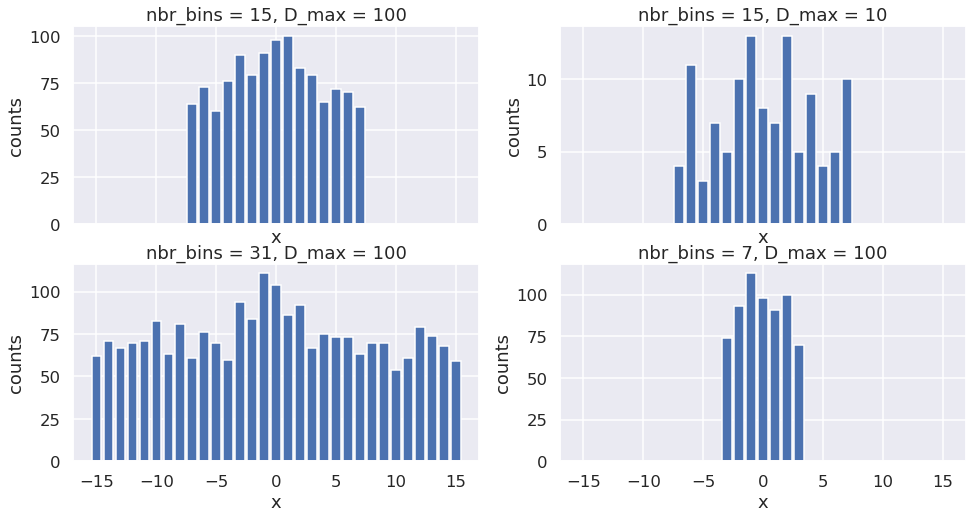

In [7]:
nbr_bins_list = [15,  15, 31,  7]
D_max_list =    [100, 10, 100, 100]
figs, axii = plt.subplots(2, 2, figsize=(16,8), sharex=True)
for nbr_bins, D_max, ax in zip(nbr_bins_list, D_max_list, axii.flatten()):
    xk_pts, Dk_pts, Nk_pts, x_max, n_0 = make_dataset(A_true, B_true, width, x_0, nbr_bins, D_max=D_max)
    true_values = exact_data(A_true, B_true, 1, xk_pts, x_0=0., width=width)

    ax.bar(xk_pts, Nk_pts)
    ax.set_xlabel("x")
    ax.set_ylabel("counts")
    ax.set_title(f"nbr_bins = {nbr_bins}, D_max = {D_max}")

Corner plots of posterior(A, B) for flat prior,.
Lighter regions correspond to higher probability in the heat map. 
An x marks the true (A,B).

nbr_bins = 15, D_max = 100:


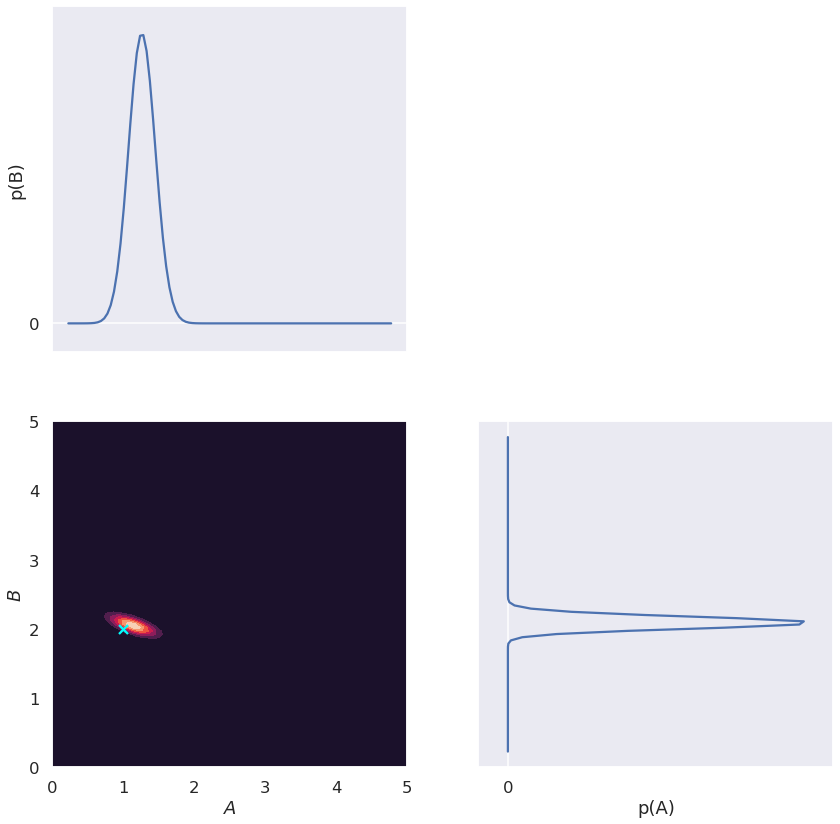

nbr_bins = 15, D_max = 10:


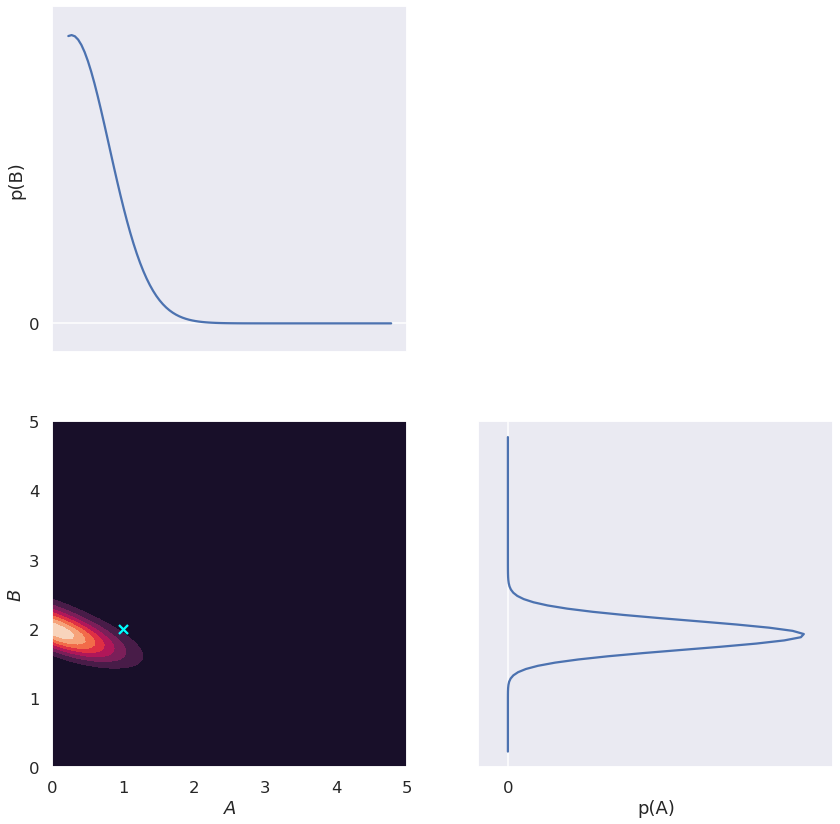

nbr_bins = 31, D_max = 100:


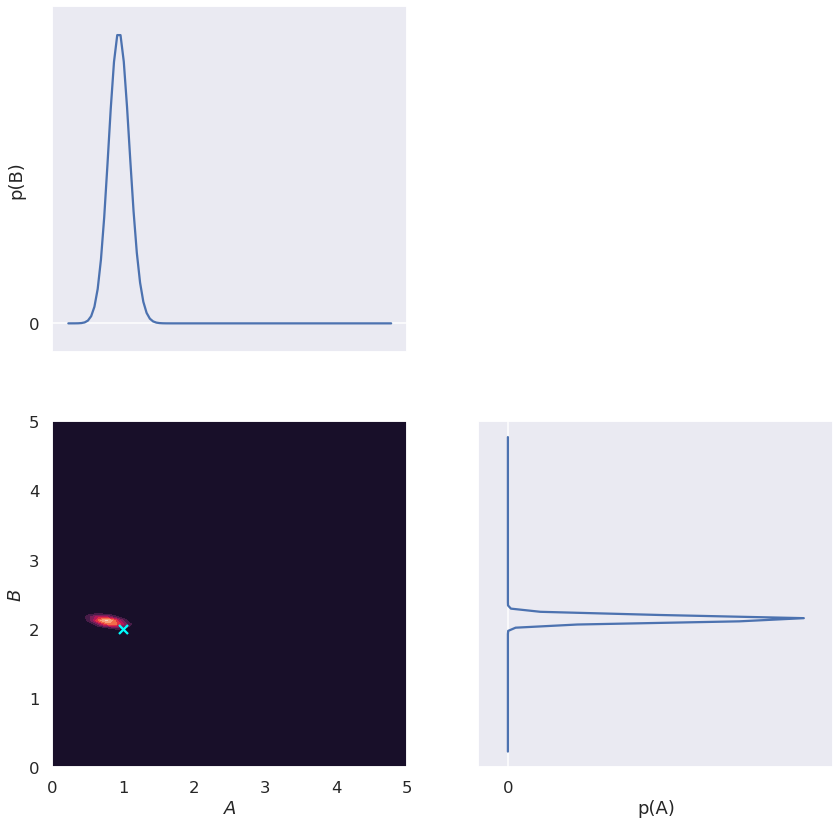

nbr_bins = 7, D_max = 100:


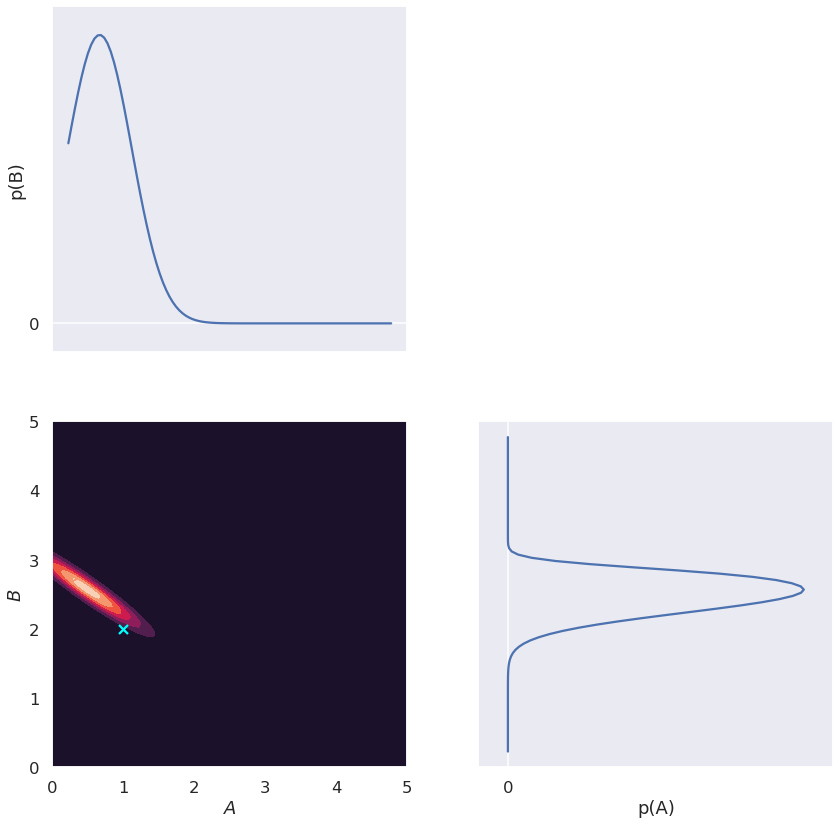

A & B are probably anticorrelated since they are "competing for the same mass" in the Nk plots.


In [8]:
print('Corner plots of posterior(A, B) for flat prior,.\n\
Lighter regions correspond to higher probability in the heat map. \n\
An x marks the true (A,B).\n')

nbr_bins_list = [15,  15, 31,  7]
D_max_list =    [100, 10, 100, 100]
for nbr_bins, D_max in zip(nbr_bins_list, D_max_list):
    xk_pts, Dk_pts, Nk_pts, x_max, n_0 = make_dataset(A_true, B_true, width, x_0, nbr_bins, D_max=D_max)

    ### define pdfs ###
    def prior(A,B):
        if  0<=A and A<=5 and 0<=B and B<=5:
            return 1.
        else:
            return 0.

    def likelihood_single(A, B, N, x):
        D = n_0 * (A * np.exp(-(x - x_0)**2 / (2 * width**2)) + B)
        return D**N * np.exp(-D) / np.math.factorial(N)

    def likelihood(A, B, N_vec, x_vec):
        likelihoods = [likelihood_single(A, B, Nk, xk) for Nk, xk in zip(N_vec, x_vec)]
        return np.prod(likelihoods) #assuming measurements independent

    def posterior(A,B):
        return prior(A,B) * likelihood(A, B, Nk_pts, xk_pts)

    ### initiate some arrays ###
    A_vec = np.linspace(0, 5, 100)
    B_vec = np.linspace(0, 5, 100)
    A_grid, B_grid = np.meshgrid(A_vec, B_vec)
    posterior_grid = np.zeros_like(A_grid) #initiate

    ### calculate posterior pdf ###
    for i, A in enumerate(A_vec):
            for j, B in enumerate(B_vec):
                posterior_grid[j,i] = posterior(A, B)

    ### plot pdf:s ###
    fig, ax = plt.subplots(2, 2, figsize=(14,14))
    ax[1,0].contourf(A_grid, B_grid, posterior_grid)
    ax[1,0].set_xlabel(r'$A$')
    ax[1,0].set_ylabel(r'$B$')
    ax[1,0].scatter(A_true, B_true, marker='x', color='cyan')

    posterior_A_margin = posterior_grid.sum(axis=0)
    ax[0,0].plot(A_vec, posterior_A_margin)
    ax[0,0].set_yticks([0])
    unit = posterior_A_margin.max()
    ax[0,0].set_ylim(bottom=-0.1*unit, top=1.1*unit)
    ax[0,0].set_xticks([])
    ax[0,0].set_ylabel(r'p(B)')

    posterior_B_margin = posterior_grid.sum(axis=1)
    ax[1,1].plot(posterior_B_margin, B_vec)
    ax[1,1].set_yticks([])
    ax[1,1].set_xticks([0])
    unit = posterior_B_margin.max()
    ax[1,1].set_xlim(left=-0.1*unit, right=1.1*unit)
    ax[1,1].set_xlabel(r'p(A)')

    ax[0,1].axis('off')
    print(f"nbr_bins = {nbr_bins}, D_max = {D_max}:")
    plt.show()

print('A & B are probably anticorrelated since they are \"competing for the same mass\" in the Nk plots.')

## Problem 4: MCMC sampling of a Lorentzian pdf using the random walk Metropolis algorithm
### (3 basic points)

Say that we have some function that tells us the (possibly unnormalized) probability of a given position in a one-dimensional space. Note, however, that a key feature of the approach that we will implement here is that it can be extended to many dimensions. 

We will assume a known, specific form of this univariate pdf, namely a Lorentzian (Cauchy) distribution, but it might just as well be some very complicated function that can only be evaluated numerically. All that is needed is some function that, for each position in the parameter space, returns a probability density.

Let us start by studying the pdf that we will be sampling from using a random walk (using the Metropolis algorithm outlined below).

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Not really needed, but nicer plots
import seaborn as sns
sns.set()
sns.set_context("talk")

In [10]:
# Modules needed for this exercise
from scipy.stats import norm
from scipy.stats import cauchy

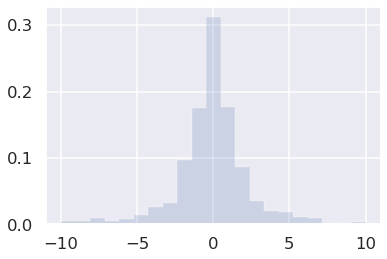

In [11]:
# Draw a number of random samples from the standard Cauchy
r = cauchy.rvs(size=1000)
plt.hist(r, density=True, histtype='stepfilled', alpha=0.2, 
         range=(-10,10),bins=21);

This histogram corresponds to a finite sample from the pdf of a standard Cauchy (Lorentzian)
$$ 
p(x | \alpha=0, \beta=1) = \frac{1}{\pi(1+x^2)}, 
$$
with mean $\alpha=0$ and FWHM $2\beta = 2$.

- How does this pdf compare with a standard normal distribution $\mathcal{N}(x;\mu=0,\sigma^2=1)$?

<font color='green'>
Cauchy distribution looks similar to normal distribution near 0 but doesn't die out as fast as $x \to \infty$. Both are symmetric.

First, turn the posterior into a callable function. You should deliberately remove the normalization to make the point that sampling can be made for an unnormalized pdf.

In [12]:
def posterior(x):
    return 1 / (1 + x**2)

### calculate L2 norm of posterior_function###
def tmp(x):
    return posterior(x)**2
n = quad(tmp, -np.inf, np.inf)[0]

def normalized_posterior(x):
    return posterior(x) / n

Now on to the sampling. The code for a MCMC sampler that uses the Metropolis algorithm is enclosed below. However, it misses a few critical steps and it is your task to add them at the correct places.

1. At first, you have the starting parameter position (that can be randomly chosen), lets fix it to the input argument `start_position`:

```python
current_position = start_position
```

Then, you propose to move (jump) from that position somewhere else (that's the Markov part). You can be very dumb or very sophisticated about how you come up with that proposal. The Metropolis sampler is very dumb and just takes a sample from a proposal distribution (here we again choose a normal distribution) centered around your current position (i.e. `current_position`) with a certain standard deviation (`proposal_width`) that will determine how far you propose jumps 

2. Use `scipy.stats.norm` to create `proposed_position` with a step based on a draw from `current_position` with a width `proposal_width`.

Next, you evaluate whether that's a good place to jump to or not. We quantify this by computing the probability of the proposed position in parameter space, i.e. evaluating the posterior pdf at the proposed position. Usually you would use log probabilities but we omit this here.

3. Compute both `p_current` and `p_proposal`.

Up until now, we essentially have a hill-climbing algorithm that would just propose movements into random directions and only accept a jump if the `proposed_position` has higher likelihood than `current_position`. Eventually we'll get to `x = 0` (or close to it) from where no more moves will be possible. However, we want to get a posterior pdf so we'll also have to sometimes accept moves into the other direction. The key trick is by dividing the two probabilities,

```python
p_accept = p_proposal / p_current
```

we get an acceptance probability. Note that the acceptance probability is obtained by dividing the posterior of proposed parameter setting by the posterior of the current parameter setting. This implies that the posterior pdf does not necessarily need to be nomalized, the normalization factor will anyway be canceled out. 

You can see that if `p_proposal` is larger, that probability will be `> 1` and we'll definitely accept. However, if `p_current` is larger, say twice as large, there'll be a 50% chance of moving there which we will decide by drawing a random number.

4. Add the acceptance step by comparing `p_accept` to a random number (uniform [0,1]). The `current_position` should be updated if the `accept` variable is `True`.

This simple procedure gives us samples from the posterior.

The code below also calls a fancy visualization function `plot_proposal` if the optional keyword argument `plot=True`.

In [13]:
def sampler(posterior_func, no_of_samples=4, start_position=.5, 
            proposal_width=1., plot=False):
    current_position = start_position # starting parameter position
    
    samples = [current_position]
    for i in range(no_of_samples):
        # suggest new position from normal distribution
        normal_distribution = norm(current_position, proposal_width)
        proposed_position = normal_distribution.rvs(size=1)[0]

        # Compute posteriors of current and proposed position
        p_current = posterior_func(current_position)
        p_proposal = posterior_func(proposed_position)
        
        p_accept = p_proposal / p_current # Acceptance probability
        p_accept = np.clip(p_accept, a_min=0, a_max=1) #probabilities are between 0 & 1

        # Note that this part will be modified in the Metropolis-Hastings algorithm 
        # for which we also consider asymmetric proposal distributions
        
        accepted = np.random.choice([True, False], p=[p_accept, 1 - p_accept]) # Accept proposal?
        if accepted:
            current_position = proposed_position
        
        # Visualization
        if plot:
            assert no_of_samples < 11, "Too many samples for visualization"
            plot_proposal(posterior_func, current_position, p_current, 
                          proposed_position, p_proposal, accepted, samples, i)

        samples.append(current_position)
    return np.array(samples)

In [14]:
# Function to display
def plot_proposal(posterior_func, current_position, p_current, 
                  proposed_position, p_proposal, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 6))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-5, 5, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot posterior
    ax1.plot(x, posterior_func(x))
    ax1.plot([current_position] * 2, [0, p_current], marker='o', color='b')
    ax1.plot([proposed_position] * 2, [0, p_proposal], marker='o', color=color)
    ax1.annotate("", xy=(proposed_position, 0.2), xytext=(current_position, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', \
            title='current: posterior(mu=%.2f) = %.2f\nproposal: posterior(mu=%.2f) = %.2f' \
            % (current_position, p_current, proposed_position, p_proposal))
    
    if accepted:
        trace.append(proposed_position)
    else:
        trace.append(current_position)
        
    # Posterior histogram
    ax2.plot(x, normalized_posterior(x)) # properly normalized
    sns.distplot(trace, kde=False, norm_hist=True, ax=ax2)
    ax2.axvline(current_position, color='b', linestyle='--', 
                label='current position')
    ax2.axvline(proposed_position, color=color, linestyle='--', 
                label='proposed position')
    ax2.annotate("", xy=(proposed_position, 0.2), xytext=(current_position, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))

    
    ax3.plot(trace)
    ax3.set(xlabel='iteration', ylabel='position', title='trace')
    plt.tight_layout()

To visualize the sampling, we'll create plots for some quantities that are computed. Each row below is a single iteration through our Metropolis sampler. These tests will also allow you to check whether your sampler works as expected.

The first column displays our unnormalized posterior distribution. This is for visualization only, normally we would not be able to plot a nice curve to show the posterior. Here, we plug in our $x$ proposals. The vertical lines represent our current position in blue and our proposed position in either red or green (rejected or accepted, respectively). 

The 2nd column is our posterior distribution. Here we are displaying the normalized posterior as the blue curve compared to the normalized histogram of samples (green bars) and the move that was just proposed.

The 3rd column is our trace (i.e. the posterior samples of visited positions that we're generating). Note that we store a sample at each iteration, irrespective of whether the propsal was accepted or rejected. In the latter situation, we keep the previous position and the line just stays constant.

Note that we always accept moves to relatively more likely $x$ values (in terms of their posterior density), but only sometimes to relatively less likely $x$ values, as can be seen already in the first iteration, and later in iterations 6, 7, and 8 (the iteration number can be found at the top center of each row).

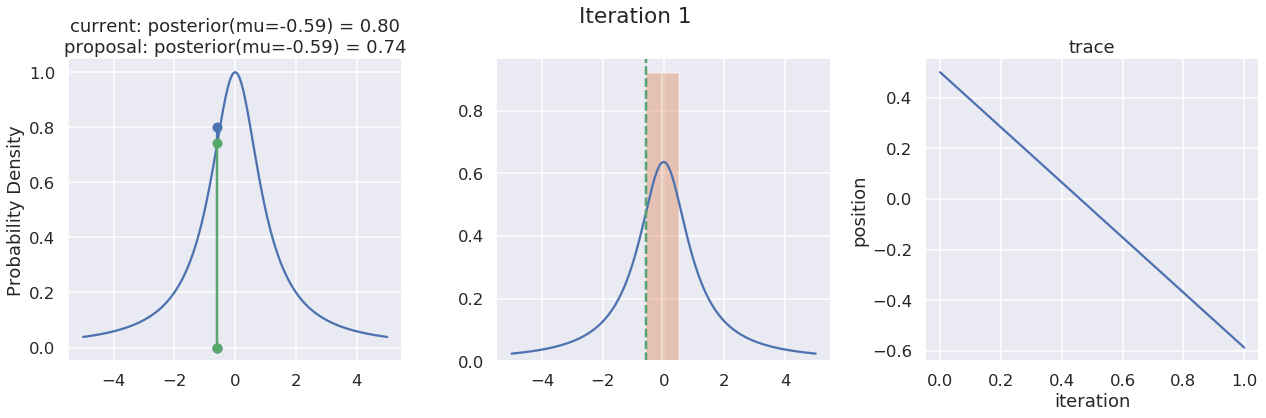

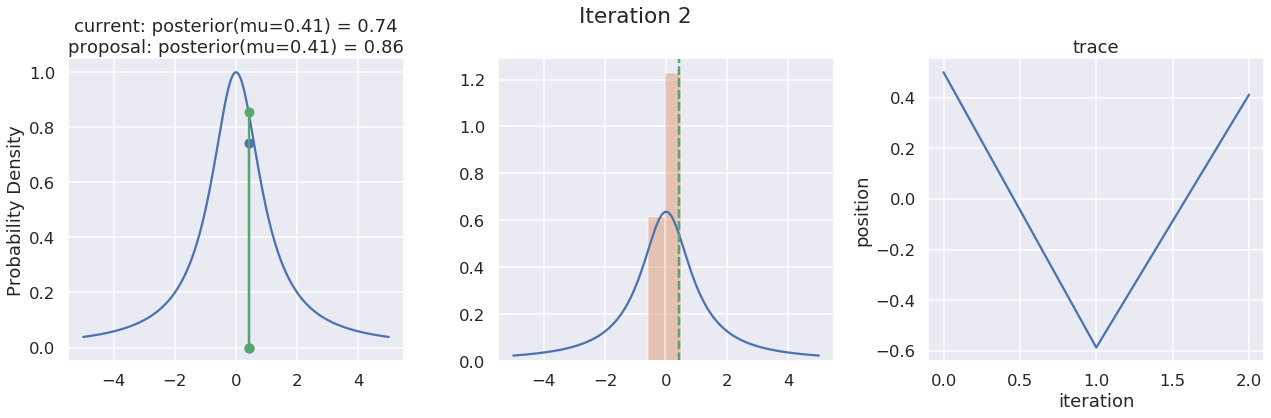

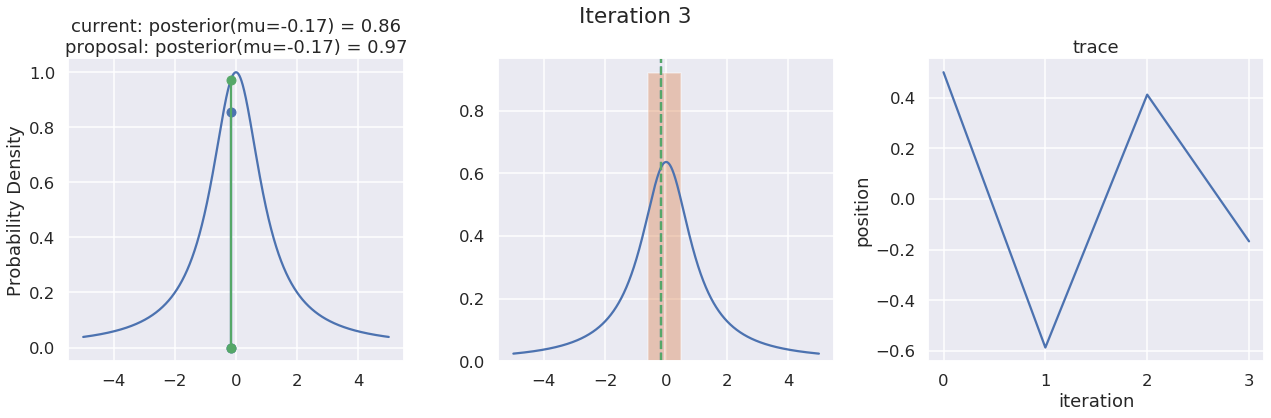

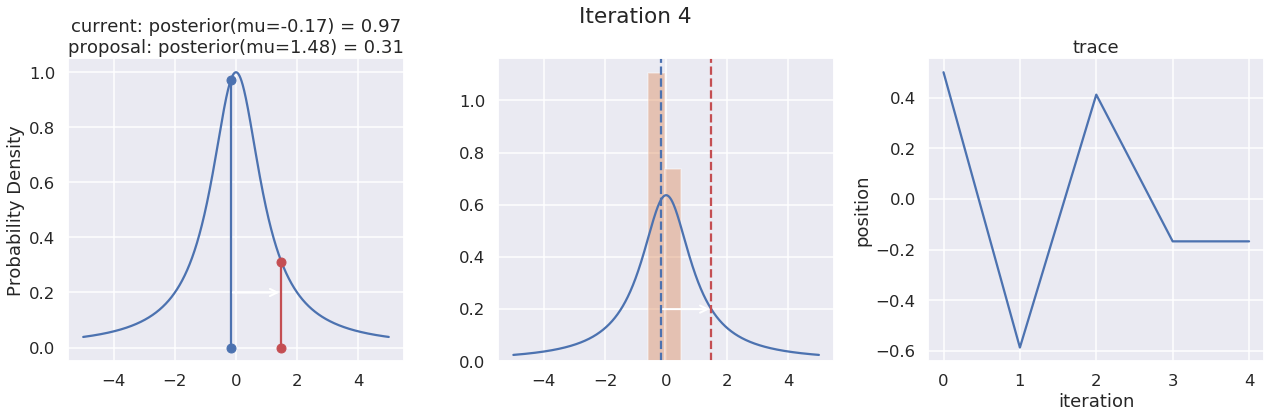

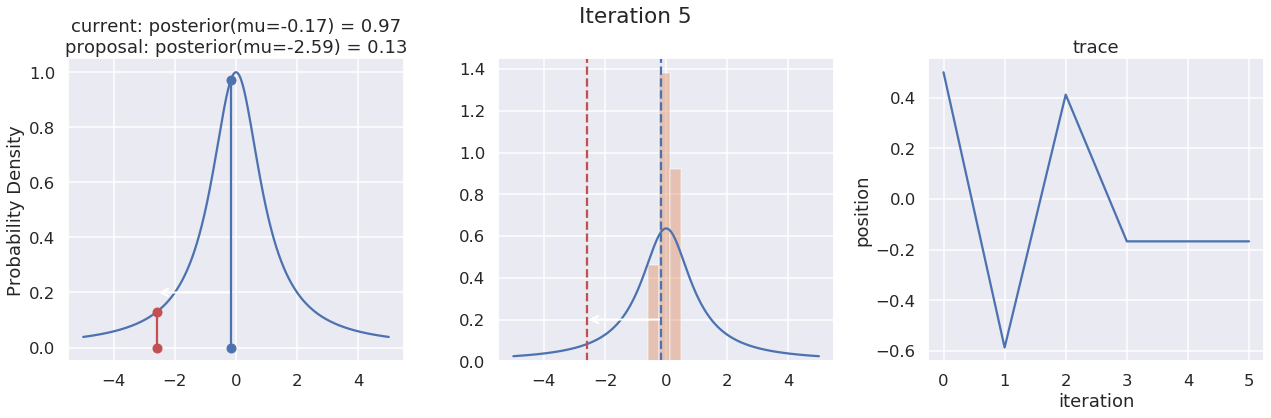

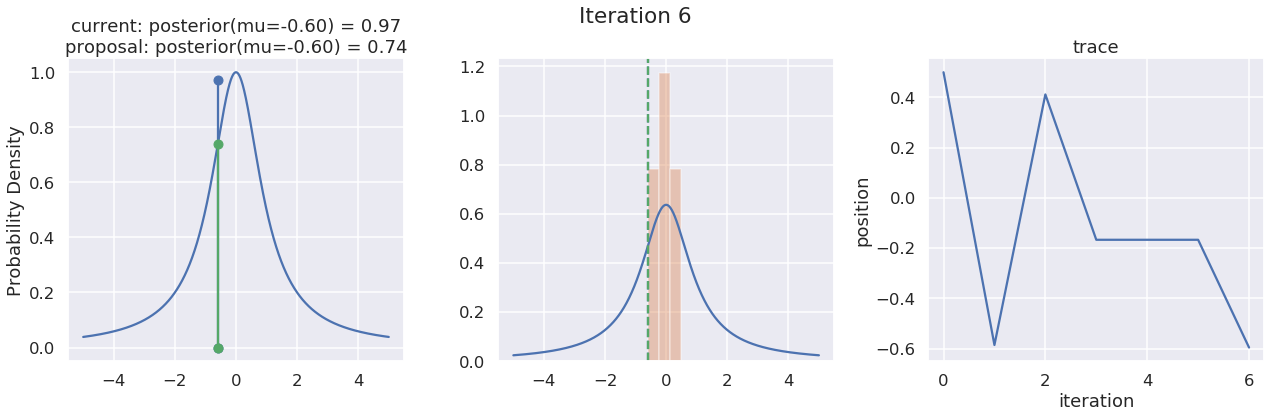

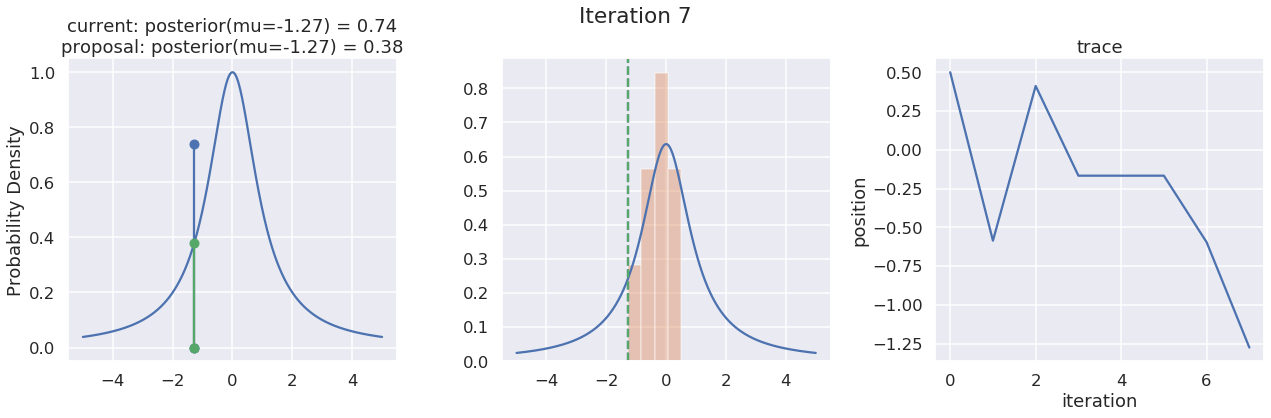

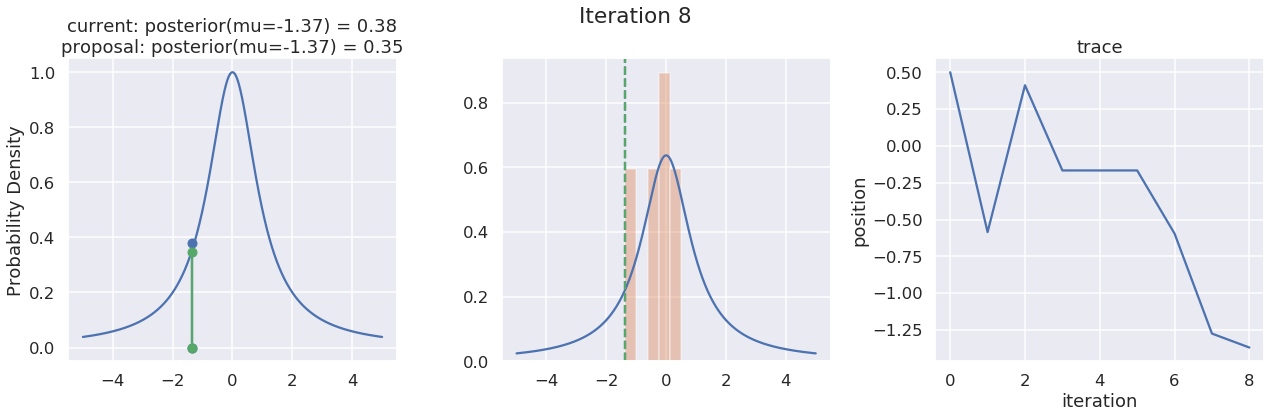

In [15]:
np.random.seed(123)
samples = sampler(posterior, no_of_samples=8, start_position=.5, proposal_width=1., plot=True);

Now the magic of MCMC is that you just have to do that for a long time, and the samples that are generated in this way come from the posterior distribution of your model. There is a rigorous mathematical proof that guarantees this which we won't go into detail here.

#### Final task:
Draw a lot of samples from your sampler (say 100.000) and plot:
* The trace (i.e. the sequence of draws of your single parameter x)
* A normalized histogram of the samples compared to the true posterior pdf (normalized).

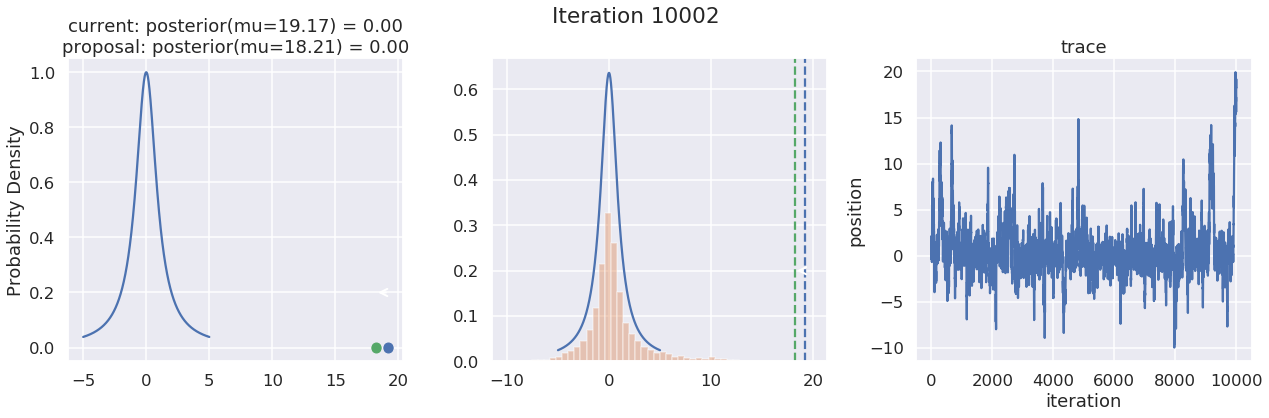

In [16]:
samples = sampler(posterior, no_of_samples=10000, start_position=.5, proposal_width=1.);
plot_proposal(posterior, samples[-2], normalized_posterior(samples[-2]), 
                          samples[-1], normalized_posterior(samples[-1]), True, [s for s in samples], len(samples))